# Survival Analysis

The main focus of this notebook is to do a survival analysis on AIH-RD.

## Objectives

1. Determine the CID with the most disparate mortality rates between males and females (percent of hospitalization).
2. Filter the data to include only the selected CID.
3. Generate a Kaplan-Meier curve stratified by gender.


## Results

CID with most disparate mortality rates between males and females:

| CID10                                     | % MortalityF | % Mortality M | delta % mortality |
| ------------------------------------------ | -----------: | -----------: | ----------------: |
| Pneumotórax                                |      18.78% |      13.27% |             5.51% |
| Pneumonite devida a sólidos e líquidos     |      34.63% |      29.40% |             5.23% |
| Neoplasia de comportamento incerto ou desconhecido |       4.85% |       9.13% |             4.28% |
| Úlcera de decúbito                          |      12.11% |       8.22% |             3.89% |
| Outras doenças do fígado                   |      12.00% |      14.99% |             2.99% |
| Infarto agudo do miocárdio                 |      10.80% |       7.97% |             2.83% |
| Choque não classificado em outra parte     |      67.51% |      70.25% |             2.74% |
| Insuficiência renal aguda                  |      20.07% |      17.49% |             2.58% |
| Outras doenças das vias biliares            |       5.17% |       7.71% |             2.54% |
| Doenças por vírus, de localização não especificada |      17.31% |      19.78% |             2.47% |

Plots at the end of the notebook

                               

In [16]:
# --- Imports ---
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import re

## 1. Determine the CID with the most disparate mortality rates between males and females (percent of hospitalization).

In [2]:
hosp_data = pd.read_csv('../data/processed/aih-rd-2022.csv', nrows = 10)
hosp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uf_zi                     10 non-null     int64  
 1   ano_cmpt                  10 non-null     int64  
 2   mes_cmpt                  10 non-null     int64  
 3   espec                     10 non-null     int64  
 4   n_aih                     10 non-null     int64  
 5   ident                     10 non-null     int64  
 6   nasc                      10 non-null     int64  
 7   sexo                      10 non-null     int64  
 8   uti_mes_in                10 non-null     int64  
 9   uti_mes_an                10 non-null     int64  
 10  uti_mes_al                10 non-null     int64  
 11  uti_mes_to                10 non-null     int64  
 12  marca_uti                 10 non-null     int64  
 13  uti_int_in                10 non-null     int64  
 14  uti_int_an   

In [ ]:
selected_cols = ['cid10_main_descricao', 'morte', 'idade', 'sexo', 'dias_perm']
hosp_data = pd.read_csv('../data/processed/aih-rd-2022.csv', usecols = selected_cols)
hosp_data.info()

# Convert sex to 'M', 'F'
hosp_data['sexo'] = np.where(
hosp_data['sexo'] == 1, 'M',
    np.where(hosp_data['sexo'] == 3, 'F', 'I')
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12520914 entries, 0 to 12520913
Data columns (total 5 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   sexo                  int64 
 1   idade                 int64 
 2   dias_perm             int64 
 3   morte                 int64 
 4   cid10_main_descricao  object
dtypes: int64(4), object(1)
memory usage: 477.6+ MB


In [ ]:
#  --- Calculate Percentage of Mortality by CID10 and Sex ---

summary_deaths = (
    hosp_data
    .groupby(['cid10_main_descricao', 'sexo', 'morte'])
    .size()
    .sort_values(ascending=False)
    .reset_index(name='n')
)

# Keep only the groups where the count 'n' exceeds 500 (arbitrary threshold to remove noise (eg men abortion)
summary_deaths = summary_deaths[summary_deaths['n'] > 500]

# Map numeric death codes (1/0) to labels 'Morte' or 'Alta' for pivoting and pivot
summary_deaths['morte'] = np.where(
    summary_deaths['morte'] == 1, 'Morte',
    np.where(summary_deaths['morte'] == 0, 'Alta', 'I')
)

summary_deaths_pivot = summary_deaths.pivot(
    index=['cid10_main_descricao', 'sexo'],
    columns='morte',
    values='n'
).reset_index()

summary_deaths_pivot.fillna(0, inplace=True)

summary_deaths_pivot['per_morte'] = (
    summary_deaths_pivot['Morte'] /
    (summary_deaths_pivot['Alta'] + summary_deaths_pivot['Morte'])
)

# --- Calculate highest mortality difference between sexes for each CID10 ---

summary_deaths_pivot.drop(['Alta', 'Morte'], axis=1, inplace=True)
summary_deaths_pivot2 = summary_deaths_pivot.pivot(
    index=['cid10_main_descricao'],
    columns='sexo',
    values='per_morte'
).reset_index()

summary_deaths_pivot2.fillna(0, inplace=True)

summary_deaths_pivot2['delta_per_morte'] = abs(
    summary_deaths_pivot2['M'] - summary_deaths_pivot2['F']
)

# Filter extremes (all death or no death)
summary_deaths_pivot2 = summary_deaths_pivot2[
    (summary_deaths_pivot2['F'] > 0) & (summary_deaths_pivot2['M'] > 0)
]
summary_deaths_pivot2 = summary_deaths_pivot2[
    (summary_deaths_pivot2['F'] < 1) & (summary_deaths_pivot2['M'] < 1)
]


# --- Get top 10 highest mortality difference between sexes for each CID10 ---
top10 = summary_deaths_pivot2.sort_values(
    'delta_per_morte', ascending=False
).head(10)

top10_cids_list = top10['cid10_main_descricao'].tolist()
top10

sexo,cid10_main_descricao,F,M,delta_per_morte
634,Pneumotórax,0.187773,0.132740,0.055033
633,Pneumonite devida a sólidos e líquidos,0.346228,0.293990,0.052238
379,Neoplasia de comportamento incerto ou desconhe...,0.048529,0.091289,0.042760
782,Úlcera de decúbito,0.121065,0.082217,0.038848
493,Outras doenças do fígado,0.120030,0.149911,0.029881
289,Infarto agudo do miocárdio,0.107987,0.079697,0.028290
73,Choque não classificado em outra parte,0.675067,0.702530,0.027463
304,Insuficiência renal aguda,0.200689,0.174924,0.025766
486,Outras doenças das vias biliares,0.051701,0.077067,0.025366
158,"Doenças por vírus, de localização não especifi...",0.173124,0.197787,0.024663


In [14]:
print(top10)


sexo                               cid10_main_descricao         F         M  \
634                                         Pneumotórax  0.187773  0.132740   
633              Pneumonite devida a sólidos e líquidos  0.346228  0.293990   
379   Neoplasia de comportamento incerto ou desconhe...  0.048529  0.091289   
782                                  Úlcera de decúbito  0.121065  0.082217   
493                            Outras doenças do fígado  0.120030  0.149911   
289                          Infarto agudo do miocárdio  0.107987  0.079697   
73               Choque não classificado em outra parte  0.675067  0.702530   
304                           Insuficiência renal aguda  0.200689  0.174924   
486                    Outras doenças das vias biliares  0.051701  0.077067   
158   Doenças por vírus, de localização não especifi...  0.173124  0.197787   

sexo  delta_per_morte  
634          0.055033  
633          0.052238  
379          0.042760  
782          0.038848  
493       

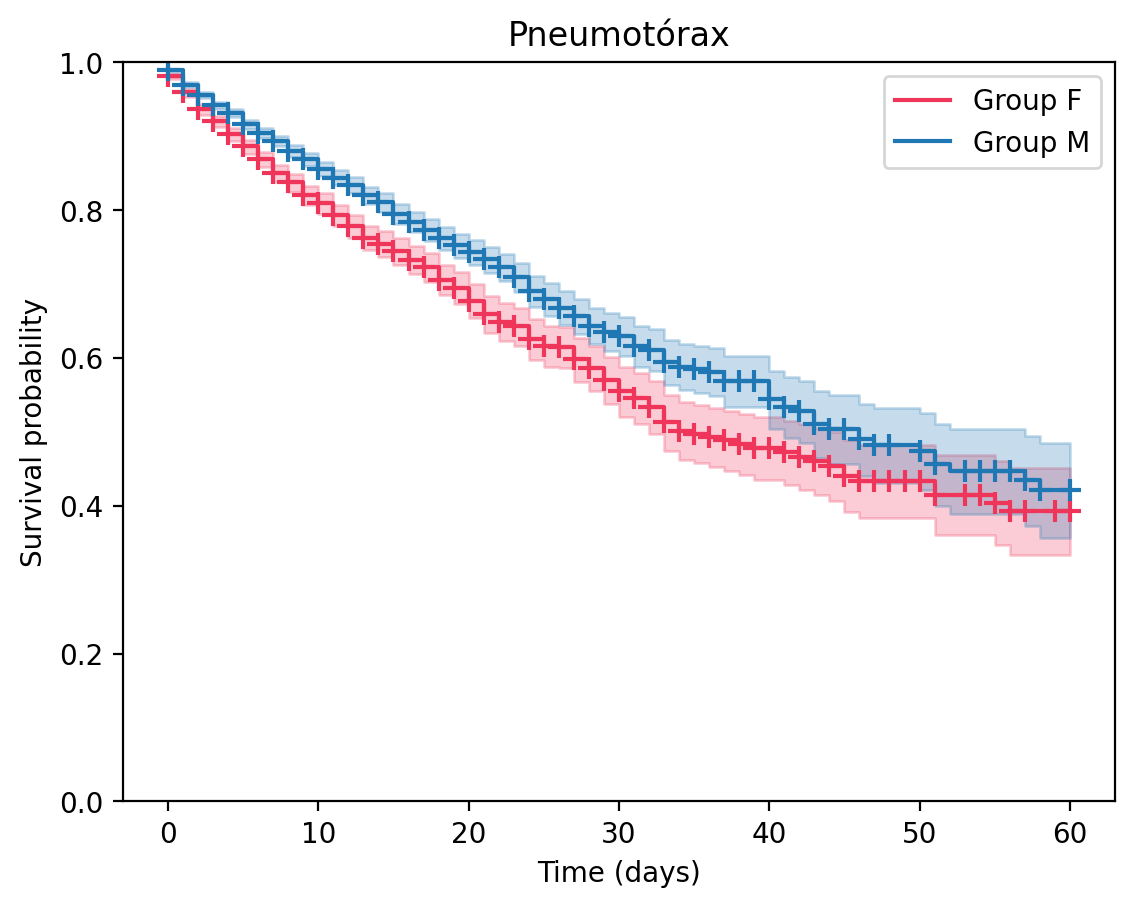

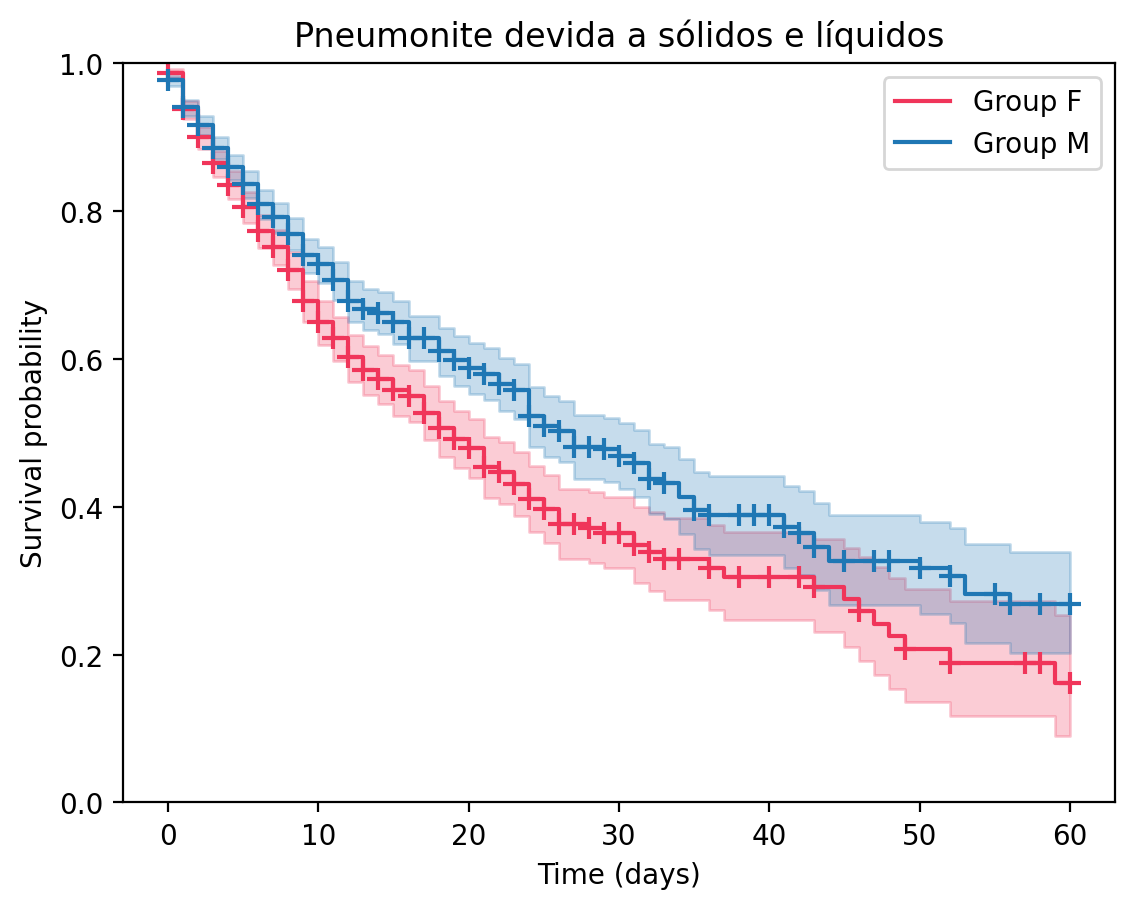

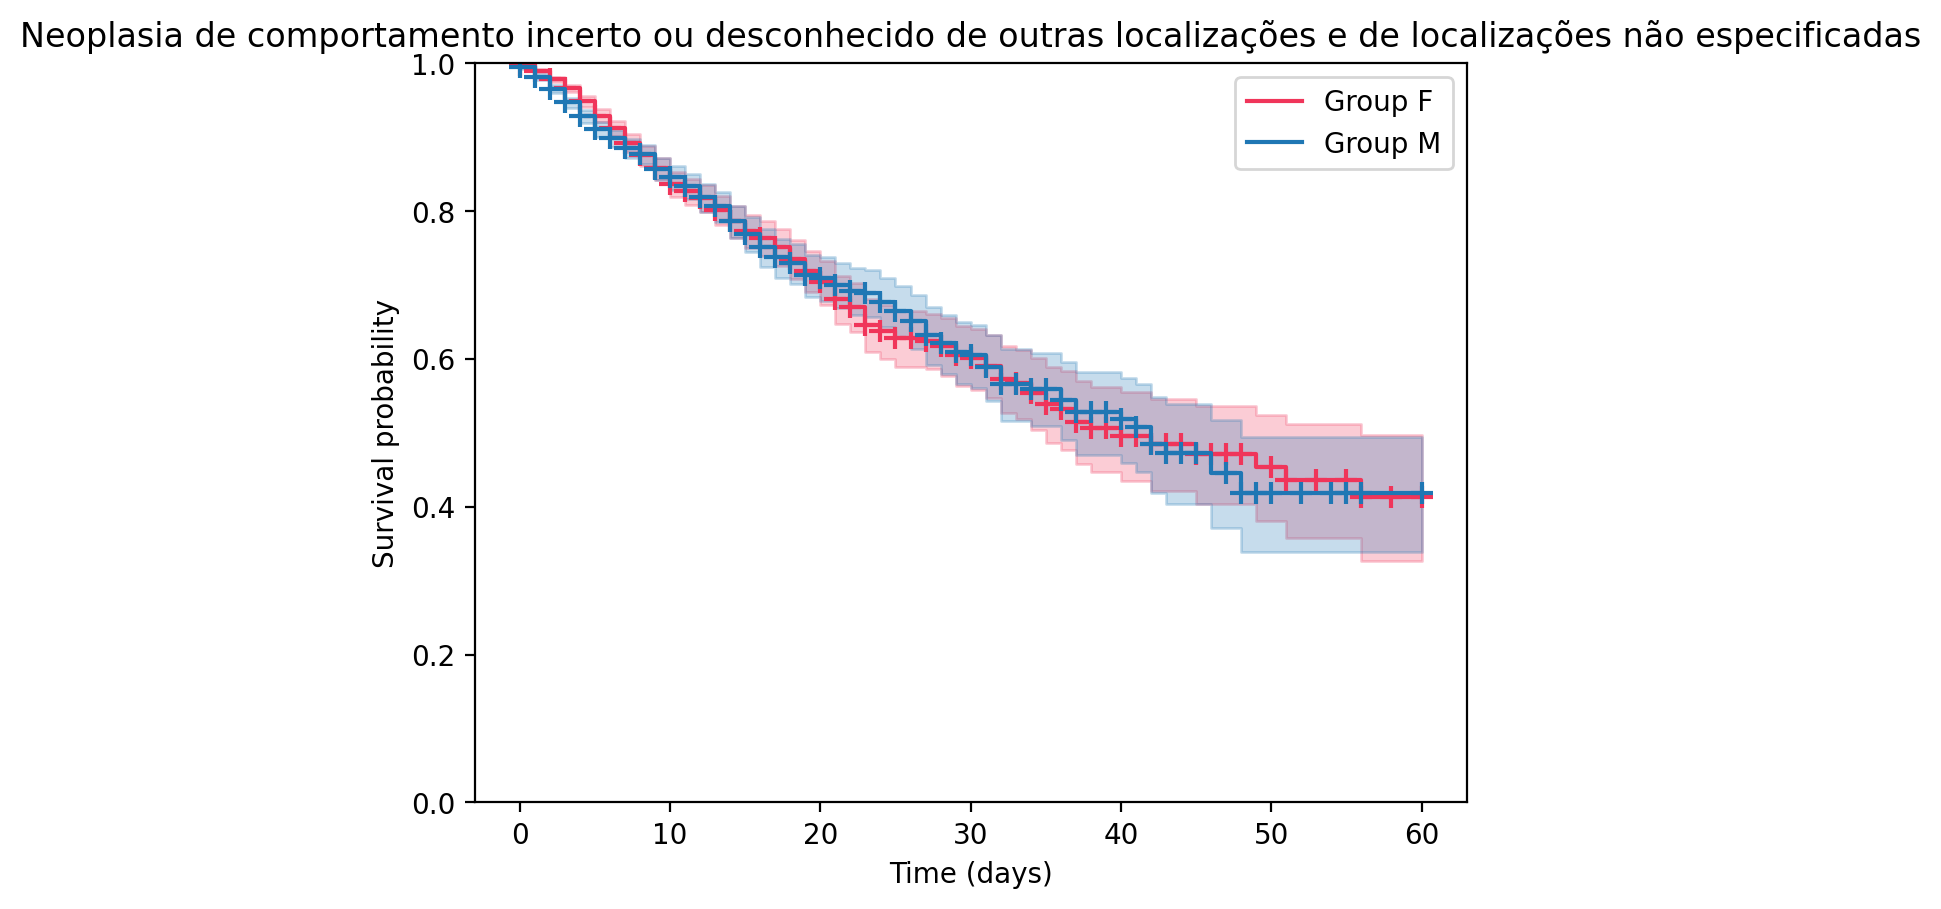

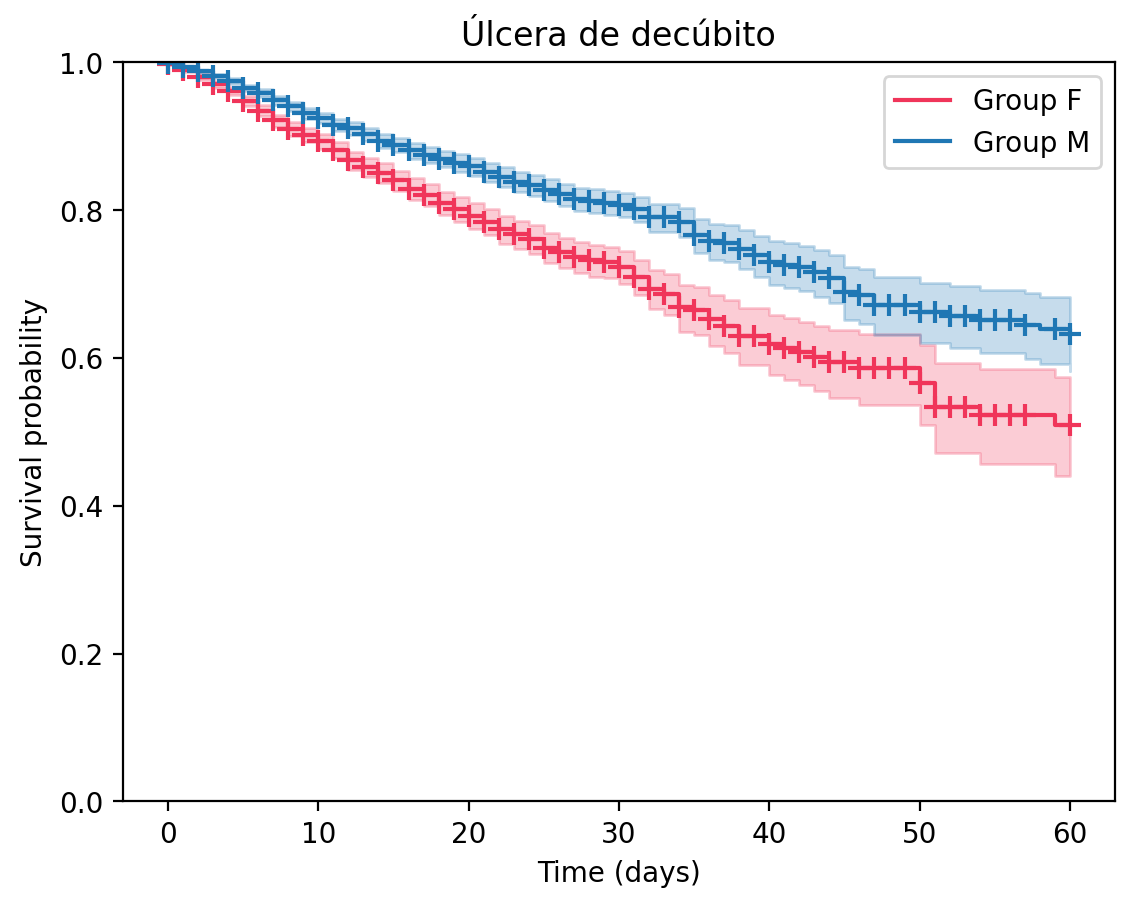

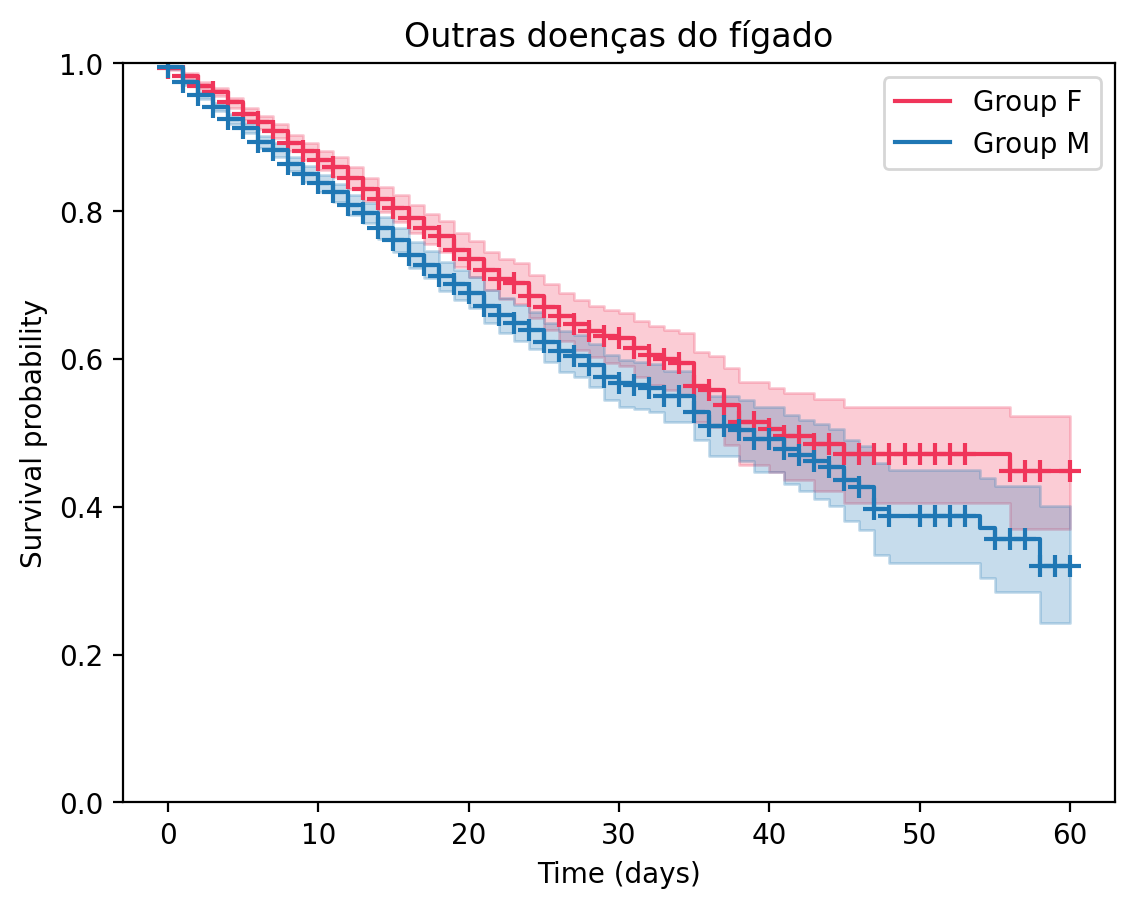

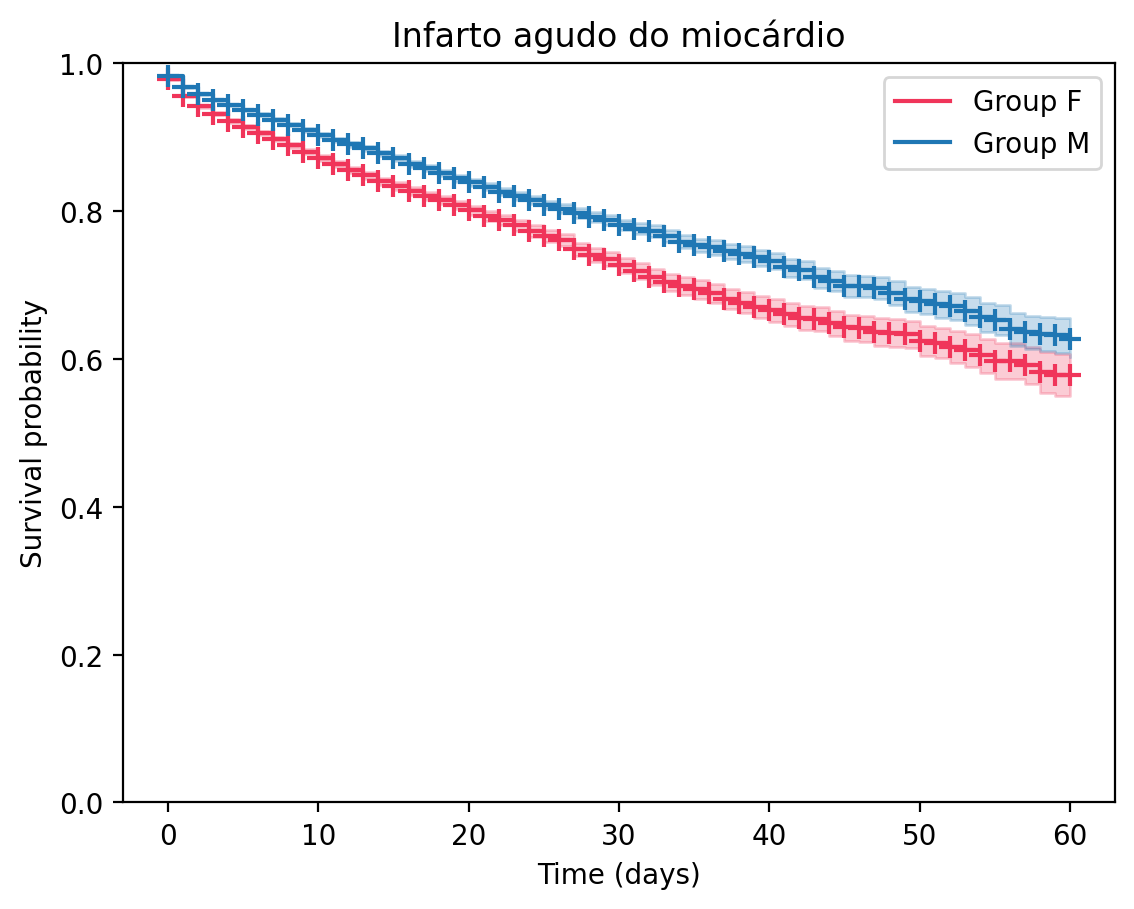

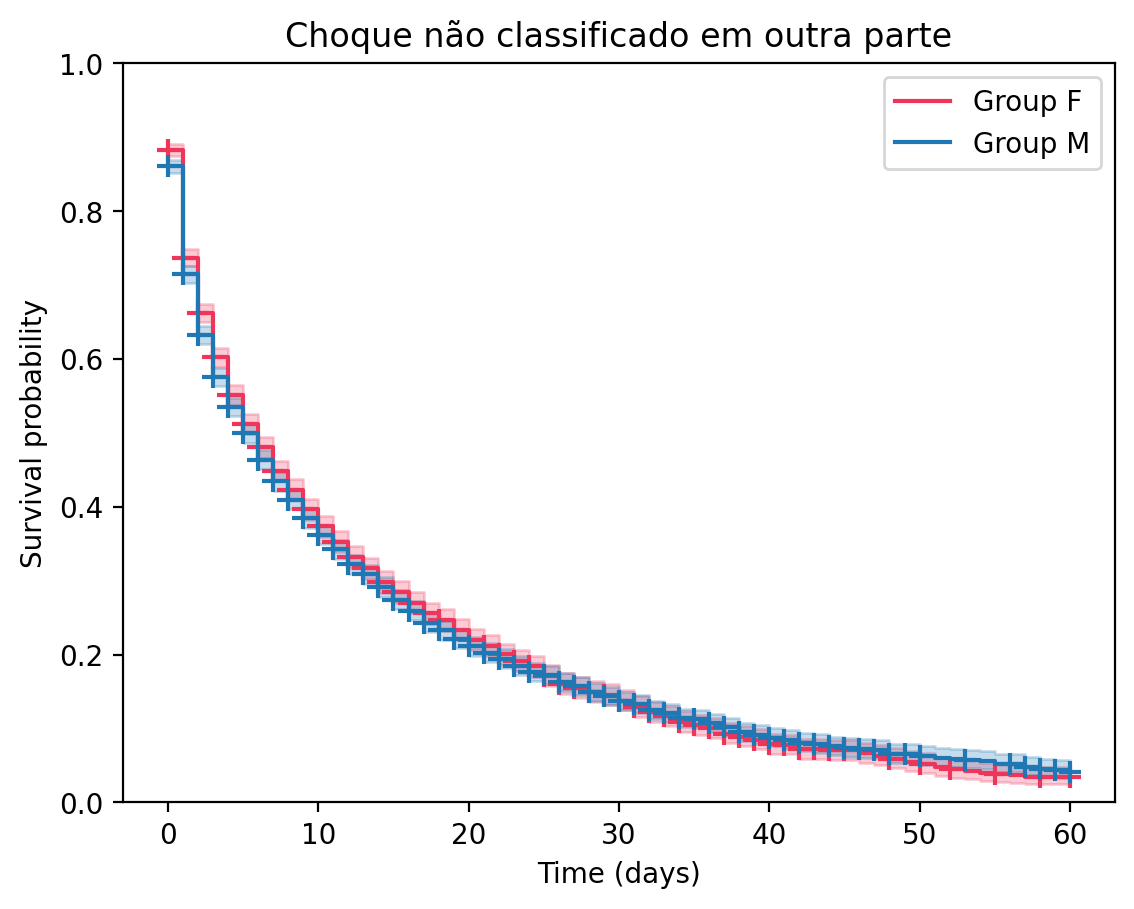

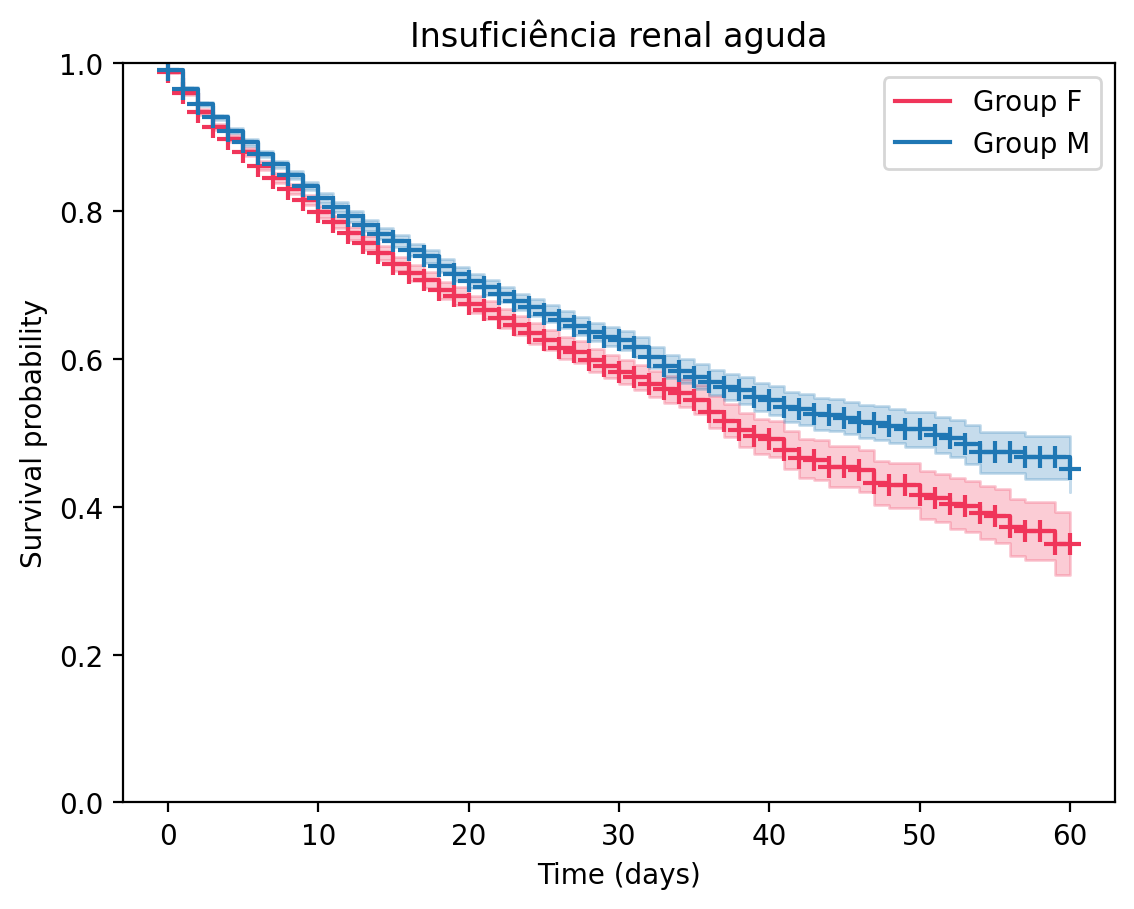

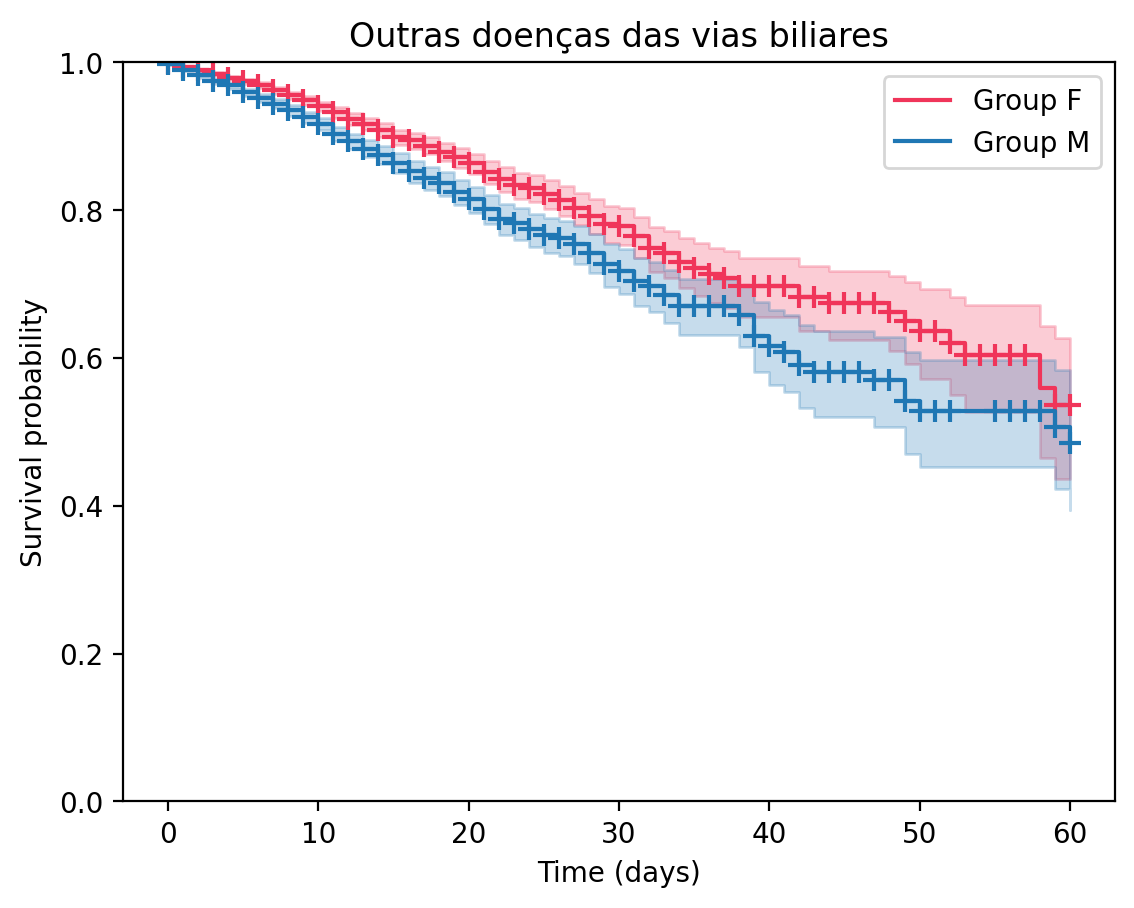

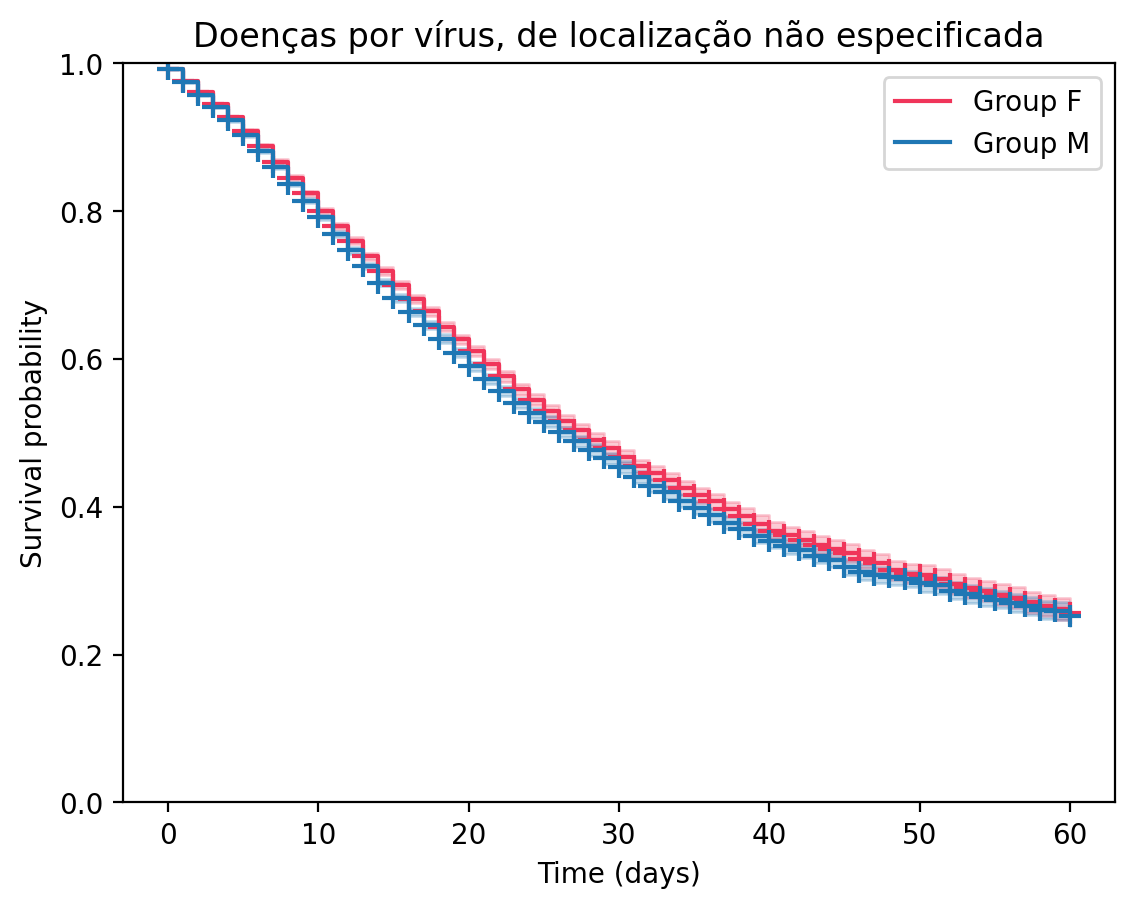

In [17]:
%config InlineBackend.figure_format = 'retina'

colors = {
    'M': '#1f77b4',
    'F': '#f0355a',
}

def slugify(column_name):
    column_name = column_name.lower()
    column_name = re.sub(r'[^\w\s-]', '', column_name)
    column_name = re.sub(r'[\s]+', '-', column_name)
    return column_name


for selected_cid in top10_cids_list:
    hosp_data_selected_cid = hosp_data[hosp_data['cid10_main_descricao'] == selected_cid]

    # Set max follow-up to two months, because data is way sparce in higher hospitalization time
    max_fu = 60
    hosp_data_selected_cid = hosp_data_selected_cid.copy()
    hosp_data_selected_cid['dias_perm_trunc'] = np.minimum(hosp_data_selected_cid['dias_perm'], max_fu)
    hosp_data_selected_cid['morte_trunc'] = np.where(hosp_data_selected_cid['dias_perm'] > max_fu, 0, hosp_data_selected_cid['morte'])

    for name, grouped_df in hosp_data_selected_cid.groupby('sexo'):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=grouped_df['dias_perm_trunc'],
                event_observed=grouped_df['morte_trunc'],
                label=f'Group {name}')

        ax = kmf.plot_survival_function(
            ci_show=True,
            color=colors.get(name),
            show_censors=True,
            censor_styles={
                'marker': '+',
                'ms': 8,
                'mew': 1.5
            }
        )
    ax.set_ylim(0, 1)
    plt.title(selected_cid)
    plt.xlabel('Time (days)')
    plt.ylabel('Survival probability')

    plt.savefig(f"../reports/figures/km-curve-{slugify(selected_cid)}.png",
            dpi=300,
            bbox_inches="tight")
    plt.show()